Introduction to Unsupervised Learning
======

In earlier labs we learned how to use linear regression to study whether certain features are significant in explaining and predicting an observed outcome. Then we used ensemble methods to refine our predictions. 

In this notebook, we shift the focus from prediction to pattern finding. 

What we'll be doing in this notebook:
-----

1. Give a general introduction to unsupervised learning.
1. Use k-means clustering as unsupervised learning technique.
1. Load and explore a dataset.
1. Find clusters with k-means algorithm.
1. Evaluate our results with the Elbow method.

Unsupervised Learning: Pattern finding in data 🔍
------

Unsupervised Learning is the process of identifying patterns in a dataset. Identifying patterns is often an early step in understanding data. Unsupervised learning methods are a set of techniques designed to <i>explore</i> and find "hidden structure" rather than predict outcomes. 
 
Unsupervised learning does not require labeled data, therefore works for broader range of data. In fact, most data in the world is unlabelled. However, since there are no labels / correct answers there is not always a clear feedback to validate that the results are correct.

Unsupervised Learning is also called Data Mining.


Unsupervised
------

2 Types of Unsupervised Learning
--------

1. Dimension Reduction

1. Clustering

What is Dimension Reduction?
------

Dimension reduction aims to find fewer number of features that be used to build a meaningful model. There are many reasons for reducing the number of features in a dataset, from avoiding overfitting to speeding up modeling fitting time.

One of the most common dimension reduction techniques is Principal Component Analysis (PCA).

What is Clustering?
-----

<center><img src="images/clustering.jpeg" width="700"/></center>

Clustering is what it sounds like: chunking your data into sub-groups (clusters) based on similar characteristics. Then these sub-groups are used for later analysis. Clustering is an intuitive to understand the various natural segments that make up the population of your data. Clustering typically makes it easier to visualizes your data.

Clustering is also called [cluster analysis](https://en.wikipedia.org/wiki/Cluster_analysis), data segmentation, or data partitioning.

We are going to focus on clustering for the rest of this notebook.

Introduction to K-means Clustering
------

![](images/k_means.png)

K-means one of the most common clustering techniques. The goal of k-means is find a group of datapoints that close to each other (a cluster) and are far away from other datapoints (the other clusters).

How do we do k-means clustering?
-----

Initially, datapoints are <i>randomly assigned</i> to a cluster. Then the center of each cluster is calculated.

Then we alternate between two steps:

1. Assignment step: Observations are assigned to a cluster where the center is closest to them.

2. Update step: New center points of clusters are determined

The process repeats until observations shuffle are long around to different cluasers anymore and the center of each cluster no longer moves.

In other words, observations are constantly being reassigned to clusters until the distance between an observation and their closest center point is minimized.

K-means Example
-----

<center><img src="http://shabal.in/visuals/kmeans/left.gif" width="700"/></center>

[Source](http://shabal.in/visuals/kmeans/2.html)

-----
Fitting K-means to Kiva Data
------

Now we are going to fit k-means to <b>partition</b> or <b>segment</b> the Kiva data into clusters.

Let's import the relevant packages to start coding:

In [176]:
# We need to clear the variables from the namespace 
# to make sure our analysis starts from stratch each time
# Add arguments to keep history and ignore confirmation

In [177]:
reset -fs 

In [178]:
# Data loading and manipulation
import pandas as pd
import numpy as np

# K-Means clustering algorithm
from sklearn.cluster import KMeans

# Plotting
import seaborn as sns

# Places the plots in the Jupyter Notebook
%matplotlib inline

# Keep everything visible
pd.set_option('display.max_columns', 80)
pd.set_option('expand_frame_repr', True)

----
Load and explore the data
-----

In [179]:
# Where the data is on the computer
path = '../data/'

filename = 'df' # Has more columns

# Load data into Pandas 🐼
df = pd.read_csv(path+filename+'.csv',
                 low_memory=False,
                 index_col=0)

# TODO: Remove these lines once this is added to feature engineering
# Normalize column names
df.columns = [c.lower().replace('.', '_').replace(' ', '_')
                 for c in df.columns]

It is always good idea 💡 to take a peak at the raw data.

In [180]:
df.head(n=2)

,unnamed:_0_1,unnamed:_0_1_1,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,description_languages,description_texts_en,description_texts_es,description_texts_fr,description_texts_ru,funded_amount,funded_date,id,image_id,image_template_id,journal_totals_bulkentries,journal_totals_entries,lender_count,loan_amount,location_country,location_country_code,location_geo_level,location_geo_pairs,location_geo_type,location_town,name,partner_id,payments,planned_expiration_date,posted_date,sector,status,tags,terms_disbursal_amount,terms_disbursal_currency,terms_disbursal_date,terms_loan_amount,terms_local_payments,...,themes,translator_byline,translator_image,use,video_id,video_thumbnailimageid,video_title,video_youtubeid,borrower_count,partner_average_loan_size_percent_per_capita_income,partner_charges_fees_and_interest,partner_countries,partner_currency_exchange_loss_rate,partner_default_rate,partner_default_rate_note,partner_delinquency_rate,partner_delinquency_rate_note,partner_image_id,partner_image_template_id,partner_loans_at_risk_rate,partner_loans_posted,partner_name,partner_portfolio_yield,partner_portfolio_yield_note,partner_profitability,partner_rating,partner_social_performance_strengths,partner_start_date,partner_status,partner_total_amount_raised,partner_url,posted_datetime,funded_datetime,planned_expiration_datetime,dispursal_datetime,number_of_loans,dispersal_date,posted_year,posted_month,time_to_fund
0,0,0,Farming,0.0,False,"[{'first_name': 'Evaline', 'last_name': '', 'g...",NaN,['en'],Evaline is a married lady aged 44 years old an...,NaN,NaN,NaN,0,NaN,1291548,2516002,1,0,0,0,500,Kenya,KE,town,-0.583333 35.183333,point,litein,Evaline,386.0,[],2017-06-08,2017-05-09,Agriculture,fundraising,"[{'name': '#Woman Owned Biz'}, {'name': '#Pare...",50000.0,KES,2017-04-03T07:00:00Z,500,"[{'due_date': '2017-05-10T07:00:00Z', 'amount'...",...,NaN,Julie Keaton,892591.0,to purchase more tea leaves to sell to the tea...,NaN,NaN,NaN,NaN,1,0.0,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.120642,0.0,NaN,7.017031,NaN,1592272.0,1.0,21.165398,1948.0,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29T13:30:02Z,active,863375.0,http://www.eclof-kenya.org/,2017-05-09 00:40:03,NaN,2017-06-08 00:40:03,2017-04-03 07:00:00,1,2017-04-03,2017,5,NaN
1,1,1,Furniture Making,0.0,False,"[{'first_name': 'Julias', 'last_name': '', 'ge...",NaN,['en'],Aged 42 years is a man by the name of Julias. ...,NaN,NaN,NaN,0,NaN,1291532,2515992,1,0,0,0,500,Kenya,KE,town,0.566667 34.566667,point,Bungoma,Julias,386.0,[],2017-06-08,2017-05-09,Manufacturing,fundraising,[],50000.0,KES,2017-04-03T07:00:00Z,500,"[{'due_date': '2017-05-09T07:00:00Z', 'amount'...",...,NaN,Morena Calvo,1832928.0,to buy timber to make more furniture for his e...,NaN,NaN,NaN,NaN,1,0.0,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.120642,0.0,NaN,7.017031,NaN,1592272.0,1.0,21.165398,1948.0,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29T13:30:02Z,active,863375.0,http://www.eclof-kenya.org/,2017-05-09 00:30:05,NaN,2017-06-08 00:30:05,2017-04-03 07:00:00,1,2017-04-03,2017,5,NaN


In [181]:
print(f"There are {df.shape[1]:,} columns in the dataframe.")
print(f"There are {df.shape[0]:,} rows in the dataframe.")

There are 86 columns in the dataframe.
There are 118,316 rows in the dataframe.


In [182]:
df.describe()

,unnamed:_0_1,unnamed:_0_1_1,basket_amount,currency_exchange_loss_amount,funded_amount,id,image_id,image_template_id,journal_totals_bulkentries,journal_totals_entries,lender_count,loan_amount,partner_id,terms_disbursal_amount,terms_loan_amount,terms_loss_liability_currency_exchange_coverage_rate,terms_repayment_term,translator_image,video_id,video_thumbnailimageid,borrower_count,partner_average_loan_size_percent_per_capita_income,partner_currency_exchange_loss_rate,partner_default_rate,partner_default_rate_note,partner_delinquency_rate,partner_delinquency_rate_note,partner_image_id,partner_image_template_id,partner_loans_at_risk_rate,partner_loans_posted,partner_portfolio_yield,partner_portfolio_yield_note,partner_profitability,partner_total_amount_raised,number_of_loans,posted_year,posted_month,time_to_fund
count,118316.000000,118316.000000,944.000000,15690.000000,118316.000000,1.183160e+05,1.183160e+05,118316.0,118316.0,118316.0,118316.000000,118316.000000,118316.000000,1.183160e+05,118316.000000,114447.000000,118316.000000,6.301700e+04,76.000000,7.600000e+01,118316.000000,118316.000000,118316.000000,118316.000000,0.0,118316.000000,0.0,1.183160e+05,118316.0,118316.000000,118316.000000,111917.000000,0.0,106890.000000,1.183160e+05,118316.0,118316.000000,118316.000000,112704.000000
mean,64433.371843,64398.230239,0.185381,7.017447,473.439771,7.096035e+05,1.540915e+06,1.0,0.0,0.0,14.608227,495.159784,165.037552,4.178579e+04,495.159784,0.122154,13.461079,1.165835e+06,1291.697368,6.155305e+05,1.930686,30.026747,0.212524,3.821426,NaN,4.358150,NaN,1.496709e+06,1.0,11.528738,18174.752434,31.054133,NaN,2.362943,7.309958e+06,1.0,2013.558783,6.424904,7.575046
std,38178.638548,38157.158427,2.145937,15.655207,676.663803,3.412929e+05,6.043467e+05,0.0,0.0,0.0,20.216517,704.079168,66.001909,4.474124e+04,704.079168,0.041529,8.147379,7.036716e+05,1027.999559,4.622450e+05,3.031490,17.099929,0.262458,10.477770,NaN,5.472373,NaN,6.022014e+05,0.0,10.893620,9423.900289,10.444965,NaN,11.299052,3.289116e+06,0.0,2.343340,3.559524,12.299220
min,0.000000,0.000000,0.000000,0.010000,0.000000,2.510000e+02,4.090000e+02,1.0,0.0,0.0,0.000000,25.000000,6.000000,2.500000e+01,25.000000,0.100000,2.000000,2.392400e+04,150.000000,2.975740e+05,1.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,3.560000e+02,1.0,0.000000,0.000000,0.000000,NaN,-117.790000,0.000000e+00,1.0,2006.000000,1.000000,-442.000000
25%,29578.750000,29564.750000,0.000000,1.220000,250.000000,4.202852e+05,1.013473e+06,1.0,0.0,0.0,7.000000,250.000000,133.000000,2.000000e+04,250.000000,0.100000,11.000000,5.186710e+05,487.750000,3.244948e+05,1.000000,24.300000,0.089354,0.085473,NaN,0.000000,NaN,1.495190e+06,1.0,0.000000,9546.000000,29.000000,NaN,-1.700000,6.764500e+06,1.0,2012.000000,3.000000,0.000000
50%,66559.500000,66517.500000,0.000000,3.490000,350.000000,6.975760e+05,1.575774e+06,1.0,0.0,0.0,11.000000,375.000000,156.000000,3.000000e+04,375.000000,0.100000,14.000000,1.186147e+06,665.500000,3.361080e+05,1.000000,34.900000,0.164711,1.483890,NaN,2.536684,NaN,1.592689e+06,1.0,16.058249,18150.000000,33.100000,NaN,0.000000,7.646925e+06,1.0,2014.000000,6.000000,2.000000
75%,98296.250000,98238.250000,0.000000,8.280000,600.000000,1.003961e+06,2.052755e+06,1.0,0.0,0.0,18.000000,600.000000,164.000000,5.000000e+04,600.000000,0.100000,14.000000,1.668411e+06,2154.250000,6.247900e+05,1.000000,40.100000,0.364948,3.652283,NaN,8.017062,NaN,2.081410e+06,1.0,18.498507,21415.000000,36.000000,NaN,2.230000,8.133425e+06,1.0,2016.000000,10.000000,13.000000
max,127957.000000,127899.000000,25.000000,1285.510000,50000.000000,1.292273e+06,2.516905e+06,1.0,0.0,0.0,1589.000000,50000.000000,526.000000,1.596948e+06,50000.000000,0.200000,122.000000,2.499150e+06,3008.000000,1.754457e+06,46.000000,54.800000,7.513861,94.939083,NaN,100.000000,NaN,2.520600e+06,1.0,100.000000,30794.000000,41.000000,NaN,30.300000,1.136698e+07,1.0,2017.000000,12.000000,62.000000


Now that we have our data set up, we can begin partitioning our data into clusters based only a few features. Let's think about how to choose these…

As a potential borrower or lender, what would be interesting to explore? 

In the previous notebooks, we explored a number of interesting ideas, including:

- How much a borrower should ask to borrow
- The time it takes to fund a loan
- What features can influence the loan amount
- If we partition borrowers into distinct groups based on how quickly they can fund a loan, will we be able to learn anything about these groups of borrowers?

The k-means algorithm uses continuous-valued numeric features (k-means  can also be modified to work with categorical and ordinal features).

-----

Let's pick a couple of interesting continuous numeric features for analysis:

How are Funded Amount and Time to Fund related?
----

In [183]:
# Keep only the relevant columns
relavant_colums = ['funded_amount', 
                   'time_to_fund']
df = df[relavant_colums] 

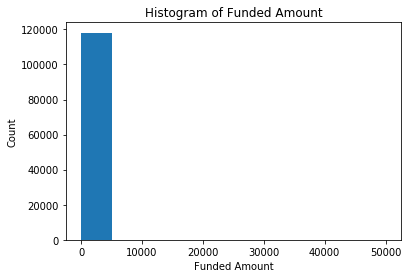

In [184]:
ax = df.funded_amount.hist(grid=False);

ax.set(xlabel='Funded Amount', 
       ylabel='Count', 
       title='Histogram of Funded Amount');  

_How can we interpret the number of loans at different funding amounts?_

<br>
<br>
<br>

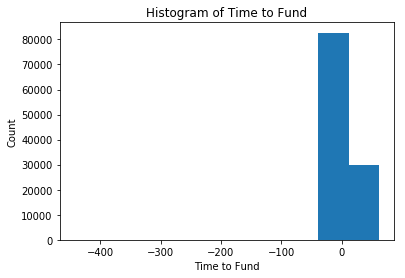

In [185]:
ax = df.time_to_fund.hist(grid=False);

ax.set(xlabel='Time to Fund', 
       ylabel='Count', 
       title='Histogram of Time to Fund');  

_How can we interpret the number of loans for different amount of times?_

<br>
<br>
<br>

In [186]:
# Filter data to remove outliers
funded_small = df.funded_amount < 2_500 # Remove large loans
time_valid = df.time_to_fund > 0 # Remove invalid times
df = df[funded_small & time_valid]

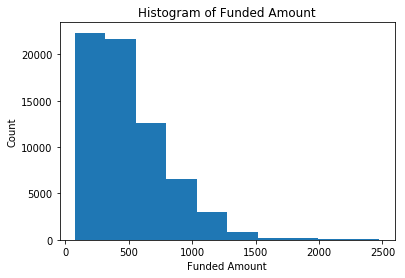

In [187]:
ax = df.funded_amount.hist(grid=False);

ax.set(xlabel='Funded Amount', 
       ylabel='Count', 
       title='Histogram of Funded Amount');  

,funded_amount,time_to_fund
86,150,1.0
99,500,1.0
100,150,1.0
127,100,1.0
148,500,2.0


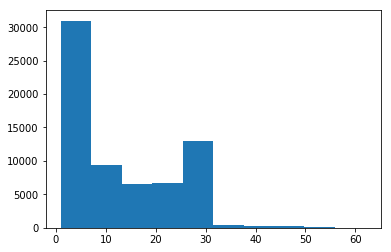

In [188]:
df.time_to_fund.hist(grid=False);df.head()

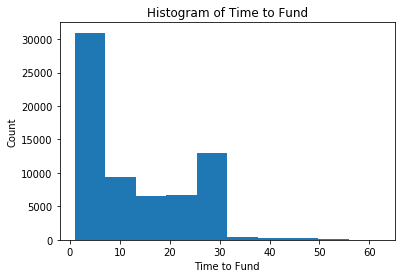

In [189]:
ax = df.time_to_fund.hist(grid=False);

ax.set(xlabel='Time to Fund', 
       ylabel='Count', 
       title='Histogram of Time to Fund');  

In [190]:
print(f"There are {df.shape[1]:,} columns in the dataframe.")
print(f"There are {df.shape[0]:,} rows in the dataframe.")

There are 2 columns in the dataframe.
There are 67,552 rows in the dataframe.


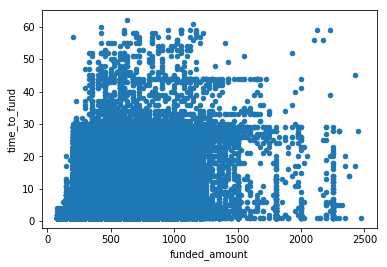

In [191]:
# Plot the relationship between these two variables
df.plot.scatter(x='funded_amount',
                y='time_to_fund');

_How can we interpret the relationship between the funded amount and time to fund?_

<br>
<br>
<br>

Clustering
======

----
Fitting our data with k-means using scikit-learn
----

Now we're ready to run the k-means algorithm:

Let's take quick peek at the [scikit-learn's documentation](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

In [192]:
# Take KMeans class, initialize and fit it our data
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [193]:
kmeans.labels_

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [194]:
# sns.lmplot(x="funded_amount", 
#            y="time_to_fund", 
#            data=df, 
#            fit_reg=False, 
#            hue=kmeans.labels_, # Use the 'hue' argument to provide a factor variable
#            legend=True);

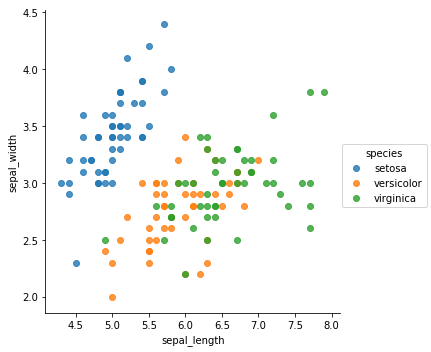

In [195]:
# TODO: Plot clusters with Seaborn

# Scratch code...
iris = sns.load_dataset('iris')

sns.lmplot(x="sepal_length", 
           y="sepal_width", 
           data=iris, 
           fit_reg=False, 
           hue='species', # Use the 'hue' argument to provide a factor variable
           legend=True);

Choosing the number of clusters
-----

The k-means algorithm is somewhat naive -- it clusters the data into k clusters, even if k is not the right number of clusters to use.

We arbitrarily set the number of clusters to be 3. But determining the appropriate number of clusters (k) is actually one of the most challenging parts of clustering. 

There is no hard and fast rule for what the value of k should be because the number of clusters will depend on your data and what the goal of your analysis. The number of groups you choose to partition in your data directly influences the results you'll find. In most areas of data analysis, it's attractive to take as granular an approach as possible, but having too many clusters can be counterproductive because the grouping will not tell you much.

_Is it possible to have too many clusters? Or too few clusters?_

Think about these extreme examples: 

1. A single cluster for all your data 
2. A cluster for each data point

Neither of these will tell you anything new about your data! 

Rather, clustering is most effective when observations in the same cluster are very similar to each other. Also, we want observations in different clusters to be as different from each other as possible.

Elbow method to explore number of clusters
------

The elbow method is a simple, intuitive way of exploring how changing the number of clusters impacts the "tightness" of the clusters. 

The idea of the elbow method is to run k-means clustering on the dataset for a range of values of k (say, k from 1 to 10 in the examples above), and for each value of k calculate the sum of squared errors (SSE).

As k increases, the centroids are closer to the clusters centroids. The improvements will decline, at some point rapidly, creating the elbow shape.

![](images/elbow_method.png)

What the elbow method does is this:

1. Run the k-means algorithm over your dataset for a range of k (say from 1 to 10)
2. For each value of k, calculate how the model fits
3. If we see an "elbow" in our plotted check, then that marks a good value for k


In [196]:
# Let's fit a different model for each value of k
k_values = range(1, 10)
k_mean_models = [KMeans(n_clusters=i) for i in k_values] # Fit a model for each value of k
scores = [-k_mean_models[i].fit(df).score(df) for i, model in enumerate(k_mean_models)] # See how the scores change

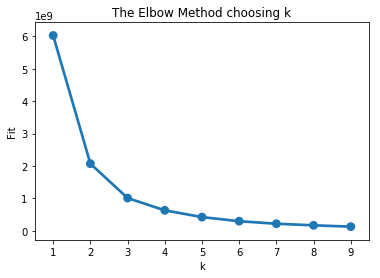

In [197]:
# Let's plot the effect k on the clustering
ax = sns.pointplot(x=list(k_values),
                   y=scores);
ax.set(xlabel='k', 
       ylabel='Fit', 
       title='The Elbow Method choosing k');

_How can we interpret the relationship between changing k and the fit of clustering? Can we see a "bend" that looks like an elbow in a arm?_

<br>
<br>
<br>

Summary
------

- We talked about how supervised learning finds patterns in data.
- Clustering is finding groups within a dataset.
- K-means clustering is a popular clustering technique that iteratively finds the best groups and center/means of groups.
- We fit k-means to data and evaluated the results.

Next Steps
-----

Apply the K-means clustering algorithm to a new pair of features. 

Then find an useful number of clusters (k).

Further study
-----

If you are interested in a more theory behind k-means, a great place to start is [here](https://www-users.cs.umn.edu/~kumar/dmbook/ch8.pdf). 

There are many other clustering methods. Another popular method is [hierarchical clustering](https://en.wikipedia.org/wiki/Hierarchical_clustering).

<br>
<br> 
<br>

----